In [1]:
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

INPUTS

In [2]:
# a parede é um cubo/quadrado determinado pelo tamanho do lado do cubo/quadrado e numero de dimensoes
tamanho_parede: float      = 10
numero_dimensoes: int      = 2
quantidade_particulas: int = 10

raio:  float = 1
massa: float = 1

velocidade_maxima: float = 100

PARTICULAS

- Classe das particulas

In [3]:
class Particula:
    def __init__(self, raio: float, massa: float, vetor_posicao: list[float], vetor_velocidade: list[float]) -> None:
        self.massa = float(massa)
        self.raio  = float(raio)
        self.vetor_posicao    = np.array(vetor_posicao, dtype= np.float64)
        self.vetor_velocidade = np.array(vetor_velocidade, dtype= np.float64)

    @property
    def momento(self) -> npt.NDArray[np.float64]:
        """Retorna um ndarray dado por: massa * velocidade"""
        return self.massa * self.vetor_velocidade
    
    @property
    def energia_cinetica(self) -> np.float64:
        """Retorna um float64 dado por: massa * <velocidade, velocidade>"""
        return self.massa * np.vdot(self.vetor_velocidade, self.vetor_velocidade)
    
    def atualizar_posicao(self, tempo_decorrido: float) -> None:
        """Usa a equação horária do movimento da partícula para atualizar sua posição um delta_t"""
        self.vetor_posicao += self.vetor_velocidade * tempo_decorrido
    
    def reflexao(self, dimensao_reflexão: int) -> None:
        """
        Edita o vetor velocidade, invertendo o sentido da velocidade na dimensão dada, como uma colisão elástica com a parede.

        Parameters
        ----------
        dimensao_reflexao : int
            0 - Inverte o sentido da velocidade em x\n
            1 - Inverte o sentido da velocidade em y\n
            2 - Inverte o sentido da velocidade em z
        """
        self.vetor_velocidade[dimensao_reflexão] = -self.vetor_velocidade[dimensao_reflexão]

    def __str__(self) -> str:
        return "Raio {}, massa {}, posicao {} e velocidade {}".format(self.raio, self.massa, self.vetor_posicao, self.vetor_velocidade)
    
    def __repr__(self) -> str:
        return "Particula({}, {}, {}, {})".format(self.raio, self.massa, self.vetor_posicao.tolist(), self.vetor_velocidade.tolist())

- RNG
- Criador de vetor aleatorio (com dimensoes certas e sem zeros)

In [4]:
# o RNG é um gerador aleatorio de float64 entre [0, 1)
rng = np.random.default_rng()

def vetor_aleatorio(valor_minimo: float, valor_maximo: float, dimensoes: int) -> npt.NDArray[np.float64]:
    """
    Gera um vetor (ndarray[float64]) com as dimensões dadas, com valores entre valor_minimo e valor_maximo, não inclusivo. Isso é para não ter problemas como iniciar na posição 0 (em colisão com parede)
    
    Returns
    -------
    vetor_aleatorio: ndarray[float64]
        Um vetor de dimensões dadas entre valor_minimo e valor_maximo, não inclusivo.
    """
    vetor_zero_a_um = rng.random(dimensoes)
    
    while min(vetor_zero_a_um) == 0:
        vetor_zero_a_um[vetor_zero_a_um == 0] = rng.random() # remapeia valores nulos, se tiver
    
    vetor_aleatorio = (valor_maximo - valor_minimo) * vetor_zero_a_um + valor_minimo

    return vetor_aleatorio

CRIADOR DE LISTA DE PARTICULAS

- Calculador de momento total de uma lista de particulas

In [5]:
def momento_total_lista(lista_de_particulas: list[Particula]) -> npt.NDArray[np.float64]:
    """Soma os vetores de momento de todas as partículas em uma lista"""
    momento_total = np.zeros(numero_dimensoes)
    
    for particula in lista_de_particulas:
        momento_total += particula.momento
        
    return momento_total

- Criador de partículas
- Criador da lista de partículas

In [6]:
# criador de particula com posicao e velocidade aleatorias
def criar_particula_aleatoria(raio: float, massa: float) -> Particula:
    """
    Returns
    -------
    particula_criada: Particula
        Uma partícula com raio e massa dados pelo usuário e a posição e a velocidade aleatorizadas (distribuição uniforme)
    """
    posicao_minima    = 0
    posicao_maxima    = tamanho_parede
    velocidade_minima = - velocidade_maxima # velocidades podem ser positivas ou negativas

    posicao_criada    = vetor_aleatorio(posicao_minima, posicao_maxima, numero_dimensoes)
    velocidade_criada = vetor_aleatorio(velocidade_minima, velocidade_maxima, numero_dimensoes)

    particula_criada = Particula(raio, massa, posicao_criada, velocidade_criada)
    return particula_criada


# criador da lista de partículas
def criar_particulas_iniciais(quantidade_particulas: int, raio: float, massa: float) -> list[Particula]: 
    """Usa a função criar_particula_aleatoria para criar a uma lista com a quantidade de partículas desejada, ajustando a última para que o momento total da lista seja zero"""
    # primeiro monta uma lista inicial das particulas
    lista_particulas = [criar_particula_aleatoria(raio, massa) for i in range(quantidade_particulas)]

    # depois calculamos o momento total das particulas (exceto a ultima)
    momento_total = momento_total_lista(lista_particulas[:-1])
    
    # e calculamos as velocidades da ultima particula para o momento total ser zero 
    ultima_particula = lista_particulas[-1]
    velocidade_ultima_particula = - momento_total / ultima_particula.massa
    ultima_particula.vetor_velocidade = velocidade_ultima_particula

    return lista_particulas
        

FUNÇÕES DAS COLISÕES
- Cálculo do vetor normal
- Cálculo das velocidades
- Atualização das velocidades

In [7]:
def vetor_normal_colisao(particula_1: Particula, particula_2: Particula) -> npt.NDArray[np.float64]:
    """
    Não usar fora da colisão!\n
    Na colisão, a magnetude do vetor distância é a soma dos raios, simplificando o cálculo do vetor normal.\n
    
    Returns
    -------
    vetor_normal: ndarray[float64]
        Nota: o vetor gerado aponta para a fora da superfície da particula_1!\n
        normal = vetor_distancia / (soma_dos_raios)
    """
    posicao_1 = particula_1.vetor_posicao
    posicao_2 = particula_2.vetor_posicao

    raio_1 = particula_1.raio
    raio_2 = particula_2.raio
    
    vetor_distancia = posicao_2 - posicao_1
    modulo_vetor_distancia = raio_1 + raio_2
    
    vetor_normal = vetor_distancia / modulo_vetor_distancia

    return vetor_normal

In [8]:
def velocidades_apos_colisao(massas: list[float], velocidades_normais: list[np.float64]) -> list[np.float64]:
    """
    No momento da colisão, podemos decompor as velocidades das partículas em suas componentes normal ao impacto (v1 e v2) e tangencial. Somente a velocidade normal é alterada.\n
    v1_nova = [ (m1 - m2) v1 -   2 m2    v2 ] / (m1 + m2)\n
    v2_nova = [   2 m1    v1 - (m1 - m2) v2 ] / (m1 + m2)

    Returns
    -------
    lista_velocidades_novas: list[float64]
        É uma lista formada pelas velocidades normais novas calculadas, na forma  [v1_nova, v2_nova]
    """
    m1, m2 = massas
    v1, v2 = velocidades_normais
    
    diff_massa = m1 - m2
    soma_massa = m1 + m2

    velocidade_1_nova = (diff_massa * v1 -    2*m2    * v2) / soma_massa
    velocidade_2_nova = (   2*m1    * v1 - diff_massa * v2) / soma_massa

    return [velocidade_1_nova, velocidade_2_nova]

In [9]:
def colisao(particula_1: Particula, particula_2: Particula) -> None:
    """
    Atualiza as velocidades das partículas durante uma colisão. Usar somente se a colisão já for confirmada.\n
    Para mudar a velocidade normal sem alterar a velocidade tangencial, o vetor da velocidade tangencial é calculado e somado com a velocidade normal nova:\n\n
    velocidade_normal     = <velocidade_antes, vetor_normal>\n
    velocidade_tangencial = velocidade_antes - velocidade_normal\n

    velocidade_antes  = velocidade_tangencial + velocidade_normal\n
    velocidade_depois = velocidade_tangencial + velocidade_normal_nova
    """
    vetor_normal = vetor_normal_colisao(particula_1, particula_2)

    massa_1 = particula_1.massa
    massa_2 = particula_2.massa

    v1_normal = np.vdot(particula_1.vetor_velocidade, vetor_normal)
    v2_normal = np.vdot(particula_2.vetor_velocidade, vetor_normal)

    vetor_v1_tangente = particula_1.vetor_velocidade - v1_normal * vetor_normal
    vetor_v2_tangente = particula_2.vetor_velocidade - v2_normal * vetor_normal

    v1_normal_novo, v2_normal_novo = velocidades_apos_colisao(massas = [massa_1, massa_2], velocidades_normais = [v1_normal, v2_normal])
    
    particula_1.vetor_velocidade = vetor_v1_tangente + v1_normal_novo * vetor_normal
    particula_2.vetor_velocidade = vetor_v2_tangente + v2_normal_novo * vetor_normal

PREVISÃO DE COLISÕES
- Colisão entre duas particulas
- Colisão contra paredes

In [85]:
numero_muito_grande = np.float64(0b111_111_111_111_111) # um valor muito grande para retornar se não for possível colisões

def tempo_colisao_particulas(particula_1: Particula, particula_2: Particula) -> np.float64:
    """
    Calcula o tempo para duas partículas se colidirem (a velocidades constantes) ou um valor bem grande, para não interferir na lista.\n
    Podemos imaginar que a distância relativa é um vetor que cresce no sentido da velocidade relativa. Nesse caso, uma colisão seria o momento delta_t que faz a distância relativa ter magnetude igual à soma dos raios das partículas

    Returns
    -------
    tempo_para_colisao: float64
        O tempo para que ocorra a colisão entre as duas partículas.
    
    numero_muito_grande: float64
        Caso não ocorra colisão, retorna um valor muito grande (2^15 - 1) para ser ignorado na lista de prioriade (variável global).
    """

    posicao_1 = particula_1.vetor_posicao
    posicao_2 = particula_2.vetor_posicao
    delta_r   = posicao_1 - posicao_2

    velocidade_1 = particula_1.vetor_velocidade
    velocidade_2 = particula_2.vetor_velocidade
    delta_v      = velocidade_1 - velocidade_2

    produto_v_r  = np.vdot(delta_r, delta_v)

    if produto_v_r >= 0: # Se a distancia relativa estiver aumentando, elas estão se afastando
        return numero_muito_grande

    raio_1 = particula_1.raio
    raio_2 = particula_2.raio
    distancia_colisao = raio_1 + raio_2

    delta_v_quadrado = np.vdot(delta_v, delta_v)
    delta_r_quadrado = np.vdot(delta_r, delta_r)

    d = produto_v_r * produto_v_r - delta_v_quadrado * (delta_r_quadrado - distancia_colisao * distancia_colisao)

    if d < 0: # se o discriminante de baskara for menor que zero, nao ha colisão
        return numero_muito_grande
    
    else:
        tempo_colisao = - (produto_v_r + np.sqrt(d)) / delta_v_quadrado
        return tempo_colisao

In [86]:
def tempo_colisao_paredes(particula: Particula) -> npt.NDArray[np.float64]:
    """
    Nota: Depende das variáveis globais numero_dimensoes para calcular as colisões em cada dimensão. Não entrar particulas com vetores de dimensões diferentes.\n
    Calcula o tempo para que a particula colida com uma parede, já levando em consideração o sentido da velocidade. Se não for possível uma colisão com a parede na dimensão checada, retorna um valor muito grande, para ser ignorado na lista de colisões.
    
    Returns
    -------
    tempos_colisao: NDArray[float64]
        Lista formada pelos tempos para a partícula colidir com a parede daquela dimensão (0 = x, 1 = y, 2 = z)

    tempo_para_colisao: float64
        O tempo para que ocorra a colisão entre as duas partículas.
    
    numero_muito_grande: float64
        Caso não ocorra colisão, retorna um valor muito grande (2^15 - 1) para ser ignorado na lista de prioriade.
    """
    tempos_colisoes = []

    posicao    = particula.vetor_posicao
    velocidade = particula.vetor_velocidade
    raio       = particula.raio
    
    for i in range(numero_dimensoes):
        if velocidade[i] > 0:
            tempo_calculado = (tamanho_parede - posicao[i] - raio) / velocidade[i]
            tempos_colisoes.append(tempo_calculado)
        
        elif velocidade[i] < 0:
            tempo_calculado = (posicao[i] - raio) / velocidade[i]
            tempos_colisoes.append(tempo_calculado)
       
        else: # Se a velocidade for zero, a partícula não tem como atingir nenhuma das duas paredes.
            tempos_colisoes.append(numero_muito_grande)
    
    return tempos_colisoes

TESTAGEM

In [84]:
teste1 = Particula(raio=1, massa=2, vetor_posicao=[0,0], vetor_velocidade=[1,1])
teste2 = Particula(raio=1, massa=2, vetor_posicao=[5,0], vetor_velocidade=[0,0])

tempo_colisao_paredes(teste1)

[9.0, 9.0]

In [10]:
angulo = 32 #°
teste1 = Particula(raio=1, massa=2, vetor_posicao=[0,0,0], vetor_velocidade=[5 * np.cos(angulo * np.pi/180), 5 * np.sin(angulo * np.pi/180), 0])
teste2 = Particula(raio=1, massa=2, vetor_posicao=[2 * np.cos(angulo * np.pi/180), 2 * np.sin(angulo * np.pi/180), 0], vetor_velocidade=[0,0,0])

print(teste1.vetor_velocidade, teste2.vetor_velocidade)
colisao(teste1, teste2)
print(teste1.vetor_velocidade, teste2.vetor_velocidade)

[4.24024048 2.64959632 0.        ] [0. 0. 0.]
[8.8817842e-16 4.4408921e-16 0.0000000e+00] [4.24024048 2.64959632 0.        ]


In [89]:
populacao = criar_particulas_iniciais(quantidade_particulas=200, raio=0.01, massa=1)

(-0.1, 10.1)

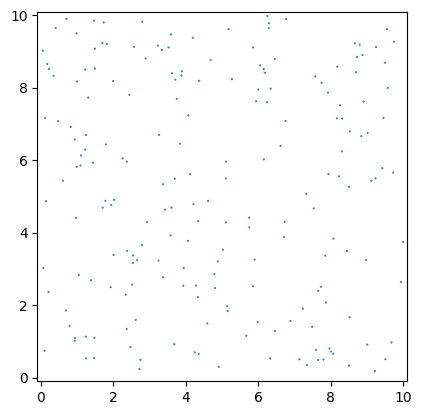

In [90]:
diametros  = []
posicoes_x = []
posicoes_y = []
posicoes_z = []
for i in populacao:
    diametros.append(2 * i.raio)
    posicoes_x.append(i.vetor_posicao[0])
    posicoes_y.append(i.vetor_posicao[1])
    # posicoes_z.append(i.vetor_posicao[2])

def tamanho_ponto_particula(diametro: float): # formula empirica para ajustar o tamanho das particulas no grafico
    return 67000 / 100 * diametro * diametro

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(posicoes_x, posicoes_y, s = [tamanho_ponto_particula(d) for d in diametros])
ax.set_aspect(1)
ax.set_xlim(-0.01 * tamanho_parede, 1.01 * tamanho_parede)
ax.set_ylim(-0.01 * tamanho_parede, 1.01 * tamanho_parede)